<a href="https://colab.research.google.com/github/SalhaAlzahrani/ConvAttenMixer/blob/main/PatchConvNet_MRI_Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with PatchConvNet (Augmenting convnets with aggregated attention)

# MRI Brain Tumor Classification

# Requirmenets

In [ ]:
pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.7 MB/s eta 0:00:00


In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Hyperparameters

In [ ]:
# DATA
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE * 2
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4  # for Brain Tumer

# AUGMENTATION
IMAGE_SIZE = 224  # We will resize input images to this size.

# ARCHITECTURE
DIMENSIONS = 256
SE_RATIO = 8
TRUNK_DEPTH = 2

# OPTIMIZER
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 30


# Load the dataset (MRI Brain Tumor Images)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# train data
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Training/',
    #directory='Brain Tumor MRI/data/Training/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    #validation_split=0.1,
    #subset="training",
    seed=1024
)

# validation data
val_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Testing/',
    #directory='Brain Tumor MRI/data/Testing/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(224, 224),
    #validation_split=0.1,
    #subset="validation",
    seed=1024
)


Mounted at /content/drive
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


# Augmentation layers

In [ ]:
def get_preprocessing():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="preprocessing",
    )
    return model

def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


# Convolutional stem
The stem of the model is a lightweight preprocessing module that maps images pixels to a set of vectors (patches).

In [ ]:
def build_convolutional_stem(dimensions):
    """Build the convolutional stem.
    Args:
        dimensions: The embedding dimension of the patches (d in paper).

    Returs:
        The convolutional stem as a keras seqeuntial model.
    """
    config = {
        "kernel_size": (3, 3),
        "strides": (2, 2),
        "activation": tf.nn.gelu,
        "padding": "same",
    }

    convolutional_stem = keras.Sequential(
        [
            layers.Conv2D(filters=dimensions // 2, **config),
            layers.Conv2D(filters=dimensions, **config),
        ],
        name="convolutional_stem",
    )

    return convolutional_stem

# Convolutional trunk
The trunk of the model is the most compute-intesive part. It consists of N stacked residual convolutional blocks.

In [ ]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in https://arxiv.org/abs/1709.01507.
    Args:
        ratio: The ratio with which the feature map needs to be reduced in the reduction phase.
    Inputs:
        Convolutional features.
    Outputs:
        Attention modified feature maps.
    """

    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio

    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config

    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()

    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x


class Trunk(layers.Layer):
    """Convolutional residual trunk as in the https://arxiv.org/abs/2112.13692
    Args:
        depth: Number of trunk residual blocks
        dimensions: Dimnesion of the model (denoted by d in the paper)
        ratio: The Squeeze-Excitation ratio
    Inputs:
        Convolutional features extracted from the conv stem.
    Outputs:
        Flattened patches.
    """

    def __init__(self, depth, dimensions, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
        self.dimensions = dimensions
        self.depth = depth

    def get_config(self):
        config = super().get_config()
        config.update(
            {"ratio": self.ratio, "dimensions": self.dimensions, "depth": self.depth,}
        )
        return config

    def build(self, input_shape):
        config = {
            "filters": self.dimensions,
            "activation": tf.nn.gelu,
            "padding": "same",
        }

        trunk_block = [
            layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(kernel_size=(1, 1), **config),
            layers.Conv2D(kernel_size=(3, 3), **config),
            SqueezeExcite(ratio=self.ratio),
            layers.Conv2D(kernel_size=(1, 1), filters=self.dimensions, padding="same"),
        ]

        self.trunk_blocks = [keras.Sequential(trunk_block) for _ in range(self.depth)]
        self.add = layers.Add()
        self.flatten_spatial = layers.Reshape((-1, self.dimensions))

    def call(self, x):
        # Remember the input.
        shortcut = x
        for trunk_block in self.trunk_blocks:
            output = trunk_block(x)
            shortcut = self.add([output, shortcut])
            x = shortcut
        # Flatten the patches.
        x = self.flatten_spatial(x)
        return x


# Attention Pooling
The output of the convolutional trunk is attended with a trainable query class token. The resulting attention map is the weight of every patch of the image for a classification decision.

In [ ]:
class AttentionPooling(layers.Layer):
    """Applies attention to the patches extracted form the trunk with the CLS token.
    Args:
        dimensions: The dimension of the whole architecture.
        num_classes: The number of classes in the dataset.
    Inputs:
        Flattened patches from the trunk.
    Outputs:
        The modifies CLS token.
    """

    def __init__(self, dimensions, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dimensions = dimensions
        self.num_classes = num_classes
        self.cls = tf.Variable(tf.zeros((1, 1, dimensions)))

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "dimensions": self.dimensions,
                "num_classes": self.num_classes,
                "cls": self.cls.numpy(),
            }
        )
        return config

    def build(self, input_shape):
        self.attention = layers.MultiHeadAttention(
            num_heads=1, key_dim=self.dimensions, dropout=0.2,
        )
        self.layer_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = keras.Sequential(
            [
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
                layers.Dropout(0.2),
                layers.Dense(units=self.dimensions, activation=tf.nn.gelu),
            ]
        )
        self.dense = layers.Dense(units=self.num_classes)
        self.flatten = layers.Flatten()

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Expand the class token batch number of times.
        class_token = tf.repeat(self.cls, repeats=batch_size, axis=0)
        # Concat the input with the trainable class token.
        x = tf.concat([class_token, x], axis=1)
        # Apply attention to x.
        x = self.layer_norm1(x)
        x, viz_weights = self.attention(
            query=x[:, 0:1], key=x, value=x, return_attention_scores=True
        )
        class_token = class_token + x
        class_token = self.layer_norm2(class_token)
        class_token = self.flatten(class_token)
        class_token = self.layer_norm3(class_token)
        class_token = class_token + self.mlp(class_token)
        # Build the logits
        logits = self.dense(class_token)
        return logits, tf.squeeze(viz_weights)[..., 1:]


# Patch convnet
The patch-convnet is shown in the figure below.
![image.png](attachment:image.png)

All the modules in the architecture are built in the earlier seciton. In this section, we stack all of the different modules together.

In [ ]:
class PatchConvNet(keras.Model):
    def __init__(
        self,
        stem,
        trunk,
        attention_pooling,
        preprocessing_model,
        train_augmentation_model,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.stem = stem
        self.trunk = trunk
        self.attention_pooling = attention_pooling
        self.train_augmentation_model = train_augmentation_model
        self.preprocessing_model = preprocessing_model

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "stem": self.stem,
                "trunk": self.trunk,
                "attention_pooling": self.attention_pooling,
                "train_augmentation_model": self.train_augmentation_model,
                "preprocessing_model": self.preprocessing_model,
            }
        )
        return config

    def _calculate_loss(self, inputs, test=False):
        images, labels = inputs
        # Augment the input images.
        if test:
            augmented_images = self.preprocessing_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, _ = self.attention_pooling(x)
        # Compute the total loss.
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, logits = self._calculate_loss(inputs)
        # Apply gradients.
        train_vars = [
            self.stem.trainable_variables,
            self.trunk.trainable_variables,
            self.attention_pooling.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)
        # Report progress.
        _, labels = inputs

        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        total_loss, logits = self._calculate_loss(inputs, test=True)
        # Report progress.
        _, labels = inputs
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        # Augment the input images.
        augmented_images = self.preprocessing_model(images)
        # Pass through the stem.
        x = self.stem(augmented_images)
        # Pass through the trunk.
        x = self.trunk(x)
        # Pass through the attention pooling block.
        logits, viz_weights = self.attention_pooling(x)
        return logits, viz_weights


# Training
We build the model, compile it, and train it.

In [ ]:
m1 = tf.keras.metrics.Recall()
m2 = tf.keras.metrics.Recall()
def my_recall(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.int32)
    actual_onehot = tf.one_hot(y_true, 4)
    actual_a = actual_onehot[1]
    pred_a = tf.reshape(y_pred[1], (1,4))
    actual_b = actual_onehot[2]
    pred_b = tf.reshape(y_pred[2], (1,4))
    m1.update_state(actual_a, pred_a)
    m2.update_state(actual_b, pred_b)
    return (m1.result() + m2.result())/2

p1 = tf.keras.metrics.Precision()
p2 = tf.keras.metrics.Precision()
def my_prec(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.int32)
    actual_onehot = tf.one_hot(y_true, 4)
    actual_a = actual_onehot[1]
    pred_a = tf.reshape(y_pred[1], (1,4))
    actual_b = actual_onehot[2]
    pred_b = tf.reshape(y_pred[2], (1,4))
    p1.update_state(actual_a, pred_a)
    p2.update_state(actual_b, pred_b)
    return (p1.result() + p2.result())/2

f1 = tfa.metrics.F1Score(num_classes=4, average='macro', threshold=0.5)
f2 = tfa.metrics.F1Score(num_classes=4, average='macro', threshold=0.5)
def my_f(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.int32)
    actual_onehot = tf.one_hot(y_true, 4)
    actual_a = actual_onehot[1]
    pred_a = tf.reshape(y_pred[1], (1,4))
    actual_b = actual_onehot[2]
    pred_b = tf.reshape(y_pred[2], (1,4))
    f1.update_state(actual_a, pred_a)
    f2.update_state(actual_b, pred_b)
    return (f1.result() + f2.result())/2

In [ ]:
train_augmentation_model = get_train_augmentation_model()
preprocessing_model = get_preprocessing()
conv_stem = build_convolutional_stem(dimensions=DIMENSIONS)
conv_trunk = Trunk(depth=TRUNK_DEPTH, dimensions=DIMENSIONS, ratio=SE_RATIO)
attention_pooling = AttentionPooling(dimensions=DIMENSIONS, num_classes=NUM_CLASSES)

patch_convnet = PatchConvNet(
    stem=conv_stem,
    trunk=conv_trunk,
    attention_pooling=attention_pooling,
    train_augmentation_model=train_augmentation_model,
    preprocessing_model=preprocessing_model,
)

# Get the optimizer.
optimizer = tfa.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# Compile and pretrain the model.
patch_convnet.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),

    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),

        my_recall, my_prec, my_f
    ],
)


In [ ]:
history = patch_convnet.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds,
)

Epoch 1/30
179/179 [==============================] - 379s 2s/step - loss: 1.3619 - accuracy: 0.2047 - my_recall: 0.4789 - my_prec: 0.3507 - my_f: 0.3907 - val_loss: 1.1346 - val_accuracy: 0.3181 - val_my_recall: 0.5837 - val_my_prec: 0.3998 - val_my_f: 0.4679
Epoch 2/30
179/179 [==============================] - 16s 89ms/step - loss: 0.8788 - accuracy: 0.2369 - my_recall: 0.6543 - my_prec: 0.4416 - my_f: 0.5241 - val_loss: 1.0556 - val_accuracy: 0.1434 - val_my_recall: 0.6830 - val_my_prec: 0.4550 - val_my_f: 0.5444
Epoch 3/30
179/179 [==============================] - 16s 89ms/step - loss: 0.7907 - accuracy: 0.2057 - my_recall: 0.7115 - my_prec: 0.4719 - my_f: 0.5665 - val_loss: 1.0365 - val_accuracy: 0.2487 - val_my_recall: 0.7359 - val_my_prec: 0.4814 - val_my_f: 0.5812
Epoch 4/30
179/179 [==============================] - 16s 89ms/step - loss: 0.7591 - accuracy: 0.2160 - my_recall: 0.7500 - my_prec: 0.4868 - my_f: 0.5903 - val_loss: 1.1035 - val_accuracy: 0.2387 - val_my_recall: 0

# Let's visualize the training progress of the model.


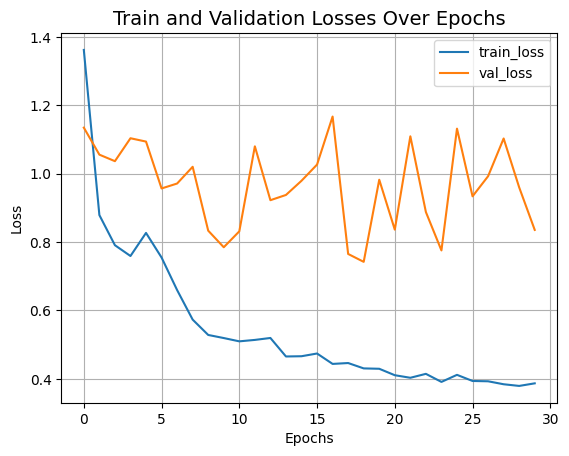

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


# Let's display the final results of the test on MRI dataset.


In [ ]:
loss, accuracy, top_5_accuracy = model.evaluate(val_ds)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


41/41 [==============================] - 110s 3s/step - loss: 0.7109 - accuracy: 0.8276 - top-5-accuracy: 1.0000
Test loss: 0.71
Test accuracy: 82.76%
Test top 5 accuracy: 100.0%


EANet just replaces self attention in Vit with external attention. The traditional Vit achieved a ~73% test top-5 accuracy and ~41 top-1 accuracy after training 50 epochs, but with 0.6M parameters. Under the same experimental environment and the same hyperparameters, The EANet model we just trained has just 0.3M parameters, and it gets us to ~73% test top-5 accuracy and ~43% top-1 accuracy. This fully demonstrates the effectiveness of external attention. We only show the training process of EANet, you can train Vit under the same experimental conditions and observe the test results.

